In [5]:
import sys
import os
sys.path.append(os.path.abspath("./"))
import ts_calculator as tc
from utils import data_visitor,data_visitor_backtest
import numpy as np
import datetime
from tqdm import tqdm
sys.path.append(os.path.abspath("../Factor_maker"))
from Factor_subclass import Factor_continuous
import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os
from ts_calculator import niomean,niostddev, threshold
from Factor import Factor
import sys
sys.path.append(os.path.abspath("./"))
from utils import array_shift,generate_dates_list,data_visitor,data_visitor_backtest
from typing import List
import pandas as pd
from abc import ABC, abstractmethod
import numpy as np
import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from ts_calculator import niomean,niostddev, threshold
sys.path.append(os.path.abspath("./"))
from utils import array_shift,generate_dates_list,data_visitor,data_visitor_backtest
from typing import List
sys.path.append(os.path.abspath("./Factor_py"))
from config import FACTOR_CONFIG

Factor class that do the backtesting for single factors

In [6]:
class Factor(ABC):
    """
    Base Factor class that represents a generic factor.
    """

    def __init__(self,asset_ret_path,crypto:List[str],alpha,start,end,shape,pnl_path,fee):
        """
        Initializes the Factor with given data.

        Args:
        - data (pd.DataFrame): A dataframe with time as rows and assets as columns.
        """

        # if not isinstance(data, pd.DataFrame):
        #     raise ValueError("Data should be a pandas DataFrame.")
        self.asset_ret_path = asset_ret_path
        self.pnl_path = pnl_path
        self.alpha = alpha
        self.dates = generate_dates_list('2021-11-1', '2023-9-1')
        self.shape = shape
        self.crypto = crypto
        self.nInstruments = len(self.crypto)
        self.pnl = np.full((self.shape[0],self.shape[1],self.shape[2]),np.nan)
        self.defee_pnl = np.full((self.shape[0],self.shape[1],self.shape[2]),np.nan)
        self.position_array = np.full((self.shape[0],self.shape[1],self.shape[2]),np.nan)
        self.start = self.dates.index(start)
        self.end = self.dates.index(end)
        self.fee = fee


    @abstractmethod
    def calculate(self,didx,tidx):
        """
        Calculates the factor value.
        Must be overridden by subclasses.
        """
        pass
        return


    @abstractmethod
    def pnl_calculate(self,didx,tidx):
        '''
        calculate pnl and store in a parquet file
        '''
        pass
        return


    
    @abstractmethod
    def one_day_process(self,didx):
        pass
        return


    def store_interval_parquet(self,interval):
        pnl = self.pnl[:,:,interval]
        pnl_defee = self.defee_pnl[:,:,interval]
        dates = np.array(self.dates)
        pnl_array = np.column_stack((dates,pnl,pnl_defee))
        pnl_df = pd.DataFrame(pnl_array,columns=["Date","Pnl","Pnl_defee"])
        path = os.path.join(self.pnl_path,f"{self.alpha}_{interval}.parquet")
        pnl_df.to_parquet(path,engine="pyarrow")
        return
    

    def store_whole_parquet(self):
        whole_pnl = np.empty((self.shape[0],self.shape[1]))
        whole_pnl_defee = np.empty((self.shape[0],self.shape[1]))
        for didx in range(self.shape[0]):
            for crypto_num, _ in enumerate(self.crypto):
                returns = np.nan_to_num(self.pnl[didx,crypto_num,:])
                returns_defee = np.nan_to_num(self.defee_pnl[didx,crypto_num,:])
                daily_pnl = np.cumprod(returns+1) - 1
                daily_pnl_defee = np.cumprod(returns_defee+1) - 1
                whole_pnl[didx,crypto_num] = daily_pnl[-1]
                whole_pnl_defee[didx,crypto_num] = daily_pnl_defee[-1]
        dates = np.array(self.dates)
        pnl_array = np.column_stack((dates,whole_pnl,whole_pnl_defee))
        pnl_df = pd.DataFrame(pnl_array,columns=["Date","Pnl","Pnl_defee"])
        path = os.path.join(self.pnl_path,f"{self.alpha}_daily.parquet")
        pnl_df.to_parquet(path,engine="pyarrow")
        return
    

    def store_parquet(self):
        for tidx in range(self.shape[2]):
            self.store_interval_parquet(tidx)
        self.store_whole_parquet()
        return
    

    def store_position(self,alpha_path):
        position_array = np.memmap(f"{alpha_path}/{self.alpha}_position",dtype="float32",mode="w+",shape=self.shape)
        position_array[:] = self.position_array
        return

    def whole_process(self,core=6):
        for didx,didx_date in tqdm(enumerate(self.dates[self.start:self.end])):
            self.one_day_process(didx)
        self.store_parquet()
        return


In [7]:
class Factor_continuous(Factor):
    def __init__(self,asset_ret_path,crypto:List[str],alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre):
        super().__init__(asset_ret_path,crypto,alpha,start,end,shape,pnl_path,fee)
        self.alpha_array = np.full((self.shape[0],self.shape[1],self.shape[2]),np.nan)
        self.alpha_zscore = np.full((self.shape[0],self.shape[1],self.shape[2]),np.nan)
        self.shape = shape
        self.back_day = back_day*shape[2]
        self.high_thre = high_thre
        self.low_thre = low_thre

    def pnl_calculate(self,didx,tidx):
        '''
        calculate pnl and store in a parquet file
        '''
        ret_array = np.memmap(self.asset_ret_path,'float32',mode='r+',shape=self.shape)
        alpha = self.calculate(didx,tidx)
        hist_alpha = data_visitor_backtest(self.alpha_array,didx,tidx,self.back_day+1,1)
        if didx < self.back_day//self.shape[2]:
            alpha_zscore = np.nan
            position = np.nan
        else:
            alpha_zscore = (alpha-niomean(hist_alpha))/niostddev(hist_alpha)
            position = threshold(alpha_zscore,self.high_thre,self.low_thre)
        last_position = data_visitor_backtest(self.position_array,didx,tidx,1,1)
        factor_ret = (position*array_shift(ret_array,didx,tidx,1))[0]-np.abs(position-last_position)*self.fee
        factor_ret_without_fee = (position*array_shift(ret_array,didx,tidx,1))[0]
        return factor_ret,alpha_zscore,position,alpha,factor_ret_without_fee


    def one_day_process(self,didx):
        for tidx in range(self.shape[2]):
            pnl,alpha_zscore,position,alpha,pnl_without_fee = self.pnl_calculate(didx+self.start,tidx)
            self.alpha_array[didx+self.start,:,tidx] = alpha
            if np.isnan(alpha_zscore):
                if tidx == 0:
                    self.alpha_zscore[didx+self.start,:,tidx] = self.alpha_zscore[didx+self.start-1,:,self.shape[2]-1]
                else:
                    self.alpha_zscore[didx + self.start, :, tidx] = self.alpha_zscore[didx + self.start - 1, :, tidx-1]
            else:
                self.alpha_zscore[didx+self.start,:,tidx] = alpha_zscore
            self.position_array[didx+self.start,:,tidx] = position
            self.pnl[didx+self.start,:,tidx] = pnl
            self.defee_pnl[didx+self.start,:,tidx] = pnl_without_fee
        return
    

    def store_alpha(self,alpha_path):
        alpha_array = np.memmap(f"{alpha_path}/{self.alpha}",dtype="float32",mode="w+",shape=self.shape)
        alpha_array[:] = self.alpha_array
        return
    

    def store_alpha_zscore(self,alpha_path):
        zscore_array = np.memmap(f"{alpha_path}/{self.alpha}_zscore",dtype="float32",mode="w+",shape=self.shape)
        zscore_array[:] = self.alpha_zscore
        return

Three Factor calculation

In [8]:
class Corr(Factor_continuous):
    def __init__(self,asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre,para_3):

        super().__init__(asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre)
        self.path = os.getcwd()
        self.para_1 = os.path.join(os.path.dirname(self.path),"Time-Series-Project","Cache\\1_h\\Volume_1h")
        self.para_2 = os.path.join(os.path.dirname(self.path),"Time-Series-Project","Cache\\1_h\\Close_1h")
        self.para_3 = para_3


    def calculate(self, didx, tidx):
        volume = data_visitor(self.para_1,didx,tidx,self.para_3,0)
        close = data_visitor(self.para_2,didx,tidx,self.para_3,0)
        corr = tc.correlation(tc.ts_zscore(volume),tc.ts_zscore(close))
        return corr


class BIAS(Factor_continuous):
    def __init__(self,asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre,para_2,para_3):

        super().__init__(asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre)
        self.path = os.getcwd()
        self.para_1 = os.path.join(os.path.dirname(self.path),"Time-Series-Project","Cache\\1_h\\Close_1h")
        self.para_2 = para_2
        self.para_3 = para_3

    def calculate(self, didx, tidx):
        close_short = data_visitor(self.para_1,didx,tidx,self.para_2,0)
        close_long = data_visitor(self.para_1,didx,tidx,self.para_3,0)
        close_short_ewa = tc.nioewa(close_short)
        close_long_ewa = tc.nioewa(close_long)
        bias = -close_short_ewa+close_long_ewa
        return bias

class Long_Short(Factor_continuous):
    def __init__(self,asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre,para_2,para_3):

        super().__init__(asset_ret_path,crypto,alpha,start,end,shape,pnl_path,back_day,fee,high_thre,low_thre)
        self.path = os.getcwd()
        self.para_1 = os.path.join(os.path.dirname(self.path),"Time-Series-Project","Cache\\5_min\\long_short_5min")
        self.para_2 = para_2
        self.para_3 = para_3

    def calculate(self, didx, tidx):
        long_short = data_visitor(self.para_1,didx,tidx,self.para_2,self.para_3,(670,1,288))
        ema_long_short = tc.nioewa(long_short)
        return -ema_long_short

Import parameters

In [9]:
pnl_path = FACTOR_CONFIG["pnl_path"]
alpha_path = FACTOR_CONFIG["alpha_path"]
cache_path = FACTOR_CONFIG["cache_path"]
start_date = FACTOR_CONFIG["start_date"]
end_date = FACTOR_CONFIG["end_date"]
back_days = FACTOR_CONFIG["back_days"]
fee = FACTOR_CONFIG["fee"]
high_thre = FACTOR_CONFIG["high_thre"]
low_thre = FACTOR_CONFIG["low_thre"]
alpha_name = FACTOR_CONFIG["alpha_name"]
asset_ret_path = FACTOR_CONFIG["asset_ret_path"]
crypto = FACTOR_CONFIG["crypto"]
shape = FACTOR_CONFIG["shape"]

In [10]:
alpha_name = f"Long_Short_Ratio"
factor = Long_Short(asset_ret_path=asset_ret_path,crypto=crypto,alpha=alpha_name,start=start_date,end = end_date,shape = shape,pnl_path = pnl_path,
                  back_day=back_days,fee = fee,high_thre=high_thre,low_thre=low_thre,para_2 = 35, para_3 = 5)
factor.whole_process()
factor.store_alpha(alpha_path)
factor.store_alpha_zscore(alpha_path)
factor.store_position(alpha_path)

alpha_name = f"BIAS"
factor = BIAS(asset_ret_path=asset_ret_path,crypto=crypto,alpha=alpha_name,start=start_date,end = end_date,shape = shape,pnl_path = pnl_path,
                  back_day=back_days,fee = fee,high_thre=high_thre,low_thre=low_thre,para_2 = 228, para_3 = 500)
factor.whole_process()
factor.store_alpha(alpha_path)
factor.store_alpha_zscore(alpha_path)
factor.store_position(alpha_path)

alpha_name = f"PV_Corr"

factor = Corr(asset_ret_path=asset_ret_path,crypto=crypto,alpha=alpha_name,start=start_date,end = end_date,shape = shape,pnl_path = pnl_path,
                  back_day=back_days,fee = fee,high_thre=high_thre,low_thre=low_thre, para_3 = 194)
factor.whole_process()
factor.store_alpha(alpha_path)
factor.store_alpha_zscore(alpha_path)
factor.store_position(alpha_path)

30it [00:00, 44.77it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_25800\1765426436.py:22: RuntimeWarning: invalid value encountered in divide
  alpha_zscore = (alpha-niomean(hist_alpha))/niostddev(hist_alpha)
56it [00:02, 25.62it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_25800\1765426436.py:22: RuntimeWarning: divide by zero encountered in divide
  alpha_zscore = (alpha-niomean(hist_alpha))/niostddev(hist_alpha)
669it [00:09, 72.69it/s] 
669it [00:46, 14.25it/s]
669it [00:10, 65.22it/s]


Factor1: Long_Short Ratio

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      48.0%

Cumulative Return   109.1%
CAGR﹪              38.72%

Sharpe              0.98
Prob. Sharpe Ratio  93.42%
Sortino             1.58
Sortino/√2          1.12
Omega               1.3

Max Drawdown        -26.14%
Longest DD Days     242

Gain/Pain Ratio     0.3
Gain/Pain (1M)      1.98

Payoff Ratio        1.24
Profit Factor       1.3
Common Sense Ratio  1.5
CPC Index           0.83
Tail Ratio          1.15
Outlier Win Ratio   10.62
Outlier Loss Ratio  3.29

MTD                 0.0%
3M                  -8.02%
6M                  23.51%
YTD                 19.33%
1Y                  47.17%
3Y (ann.)           38.72%
5Y (ann.)           38.72%
10Y (ann.)          38.72%
All-time (ann.)     38.72%

Avg. Drawdown       -7.19%
Avg. Drawdown Days  33
Recovery Factor     3.58
Ulcer Index         0.12
Serenity Index      0.98


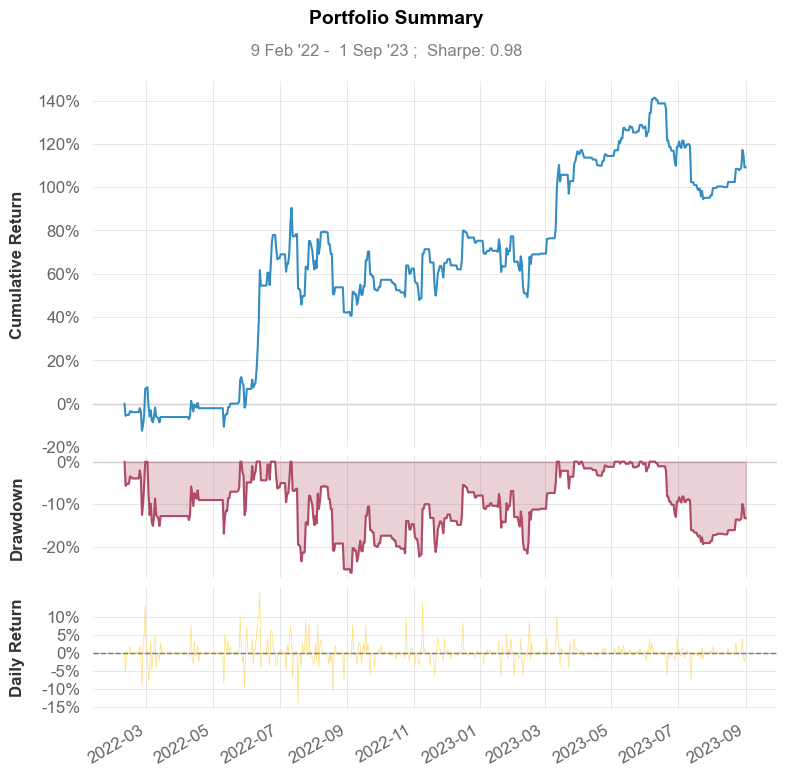

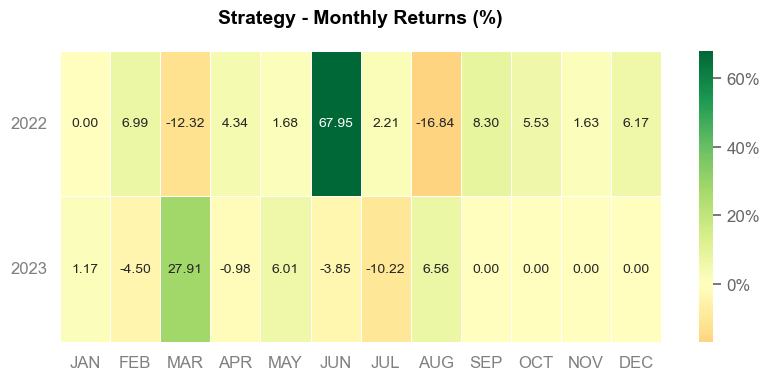

In [2]:
import quantstats as qs
import pandas as pd


file = "Long_Short_Ratio_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])

With 0.05% transaction cost

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      64.0%

Cumulative Return   80.13%
CAGR﹪              29.84%

Sharpe              0.83
Prob. Sharpe Ratio  89.68%
Sortino             1.32
Sortino/√2          0.93
Omega               1.25

Max Drawdown        -27.42%
Longest DD Days     243

Gain/Pain Ratio     0.25
Gain/Pain (1M)      1.52

Payoff Ratio        2.04
Profit Factor       1.25
Common Sense Ratio  1.38
CPC Index           0.97
Tail Ratio          1.11
Outlier Win Ratio   8.45
Outlier Loss Ratio  5.49

MTD                 0.0%
3M                  -10.83%
6M                  16.9%
YTD                 11.37%
1Y                  31.5%
3Y (ann.)           29.84%
5Y (ann.)           29.84%
10Y (ann.)          29.84%
All-time (ann.)     29.84%

Avg. Drawdown       -6.25%
Avg. Drawdown Days  28
Recovery Factor     2.87
Ulcer Index         0.14
Serenity Index      0.6

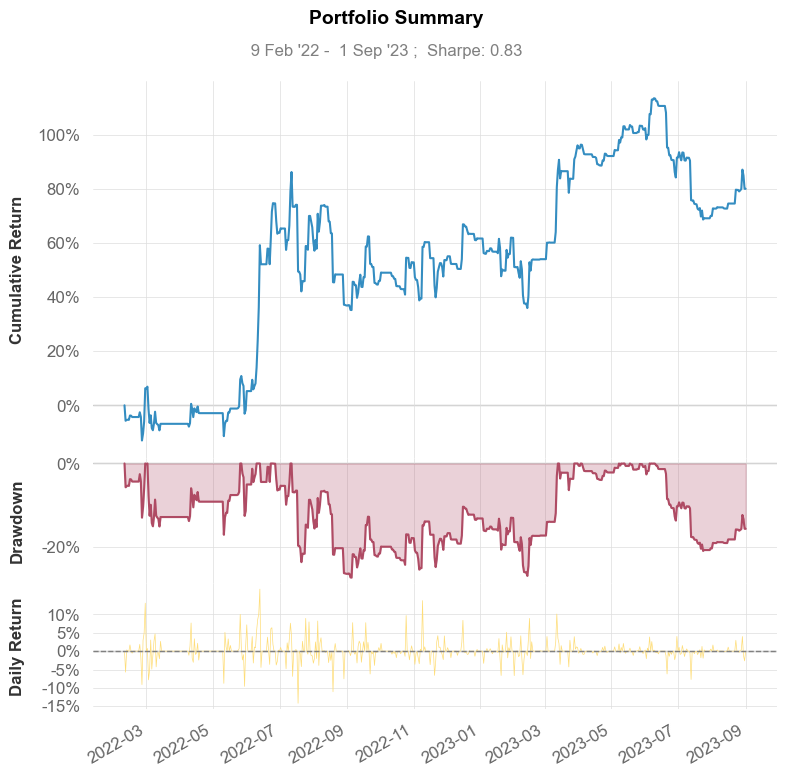

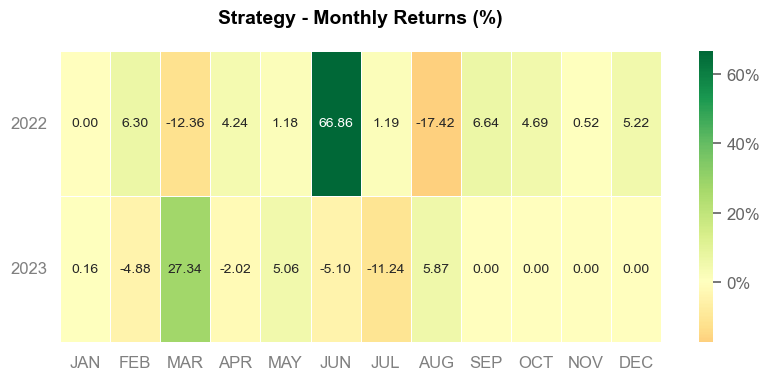

In [3]:
qs.reports.basic(df["Pnl"])

Factor2: BIAS

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   97.18%
CAGR﹪              35.15%

Sharpe              0.94
Prob. Sharpe Ratio  92.46%
Sortino             1.49
Sortino/√2          1.05
Omega               1.27

Max Drawdown        -36.8%
Longest DD Days     136

Gain/Pain Ratio     0.27
Gain/Pain (1M)      1.73

Payoff Ratio        1.2
Profit Factor       1.27
Common Sense Ratio  1.59
CPC Index           0.79
Tail Ratio          1.25
Outlier Win Ratio   8.64
Outlier Loss Ratio  3.4

MTD                 0.0%
3M                  9.55%
6M                  30.12%
YTD                 18.26%
1Y                  70.82%
3Y (ann.)           35.15%
5Y (ann.)           35.15%
10Y (ann.)          35.15%
All-time (ann.)     35.15%

Avg. Drawdown       -8.46%
Avg. Drawdown Days  33
Recovery Factor     2.35
Ulcer Index         0.14
Serenity Index      0.61


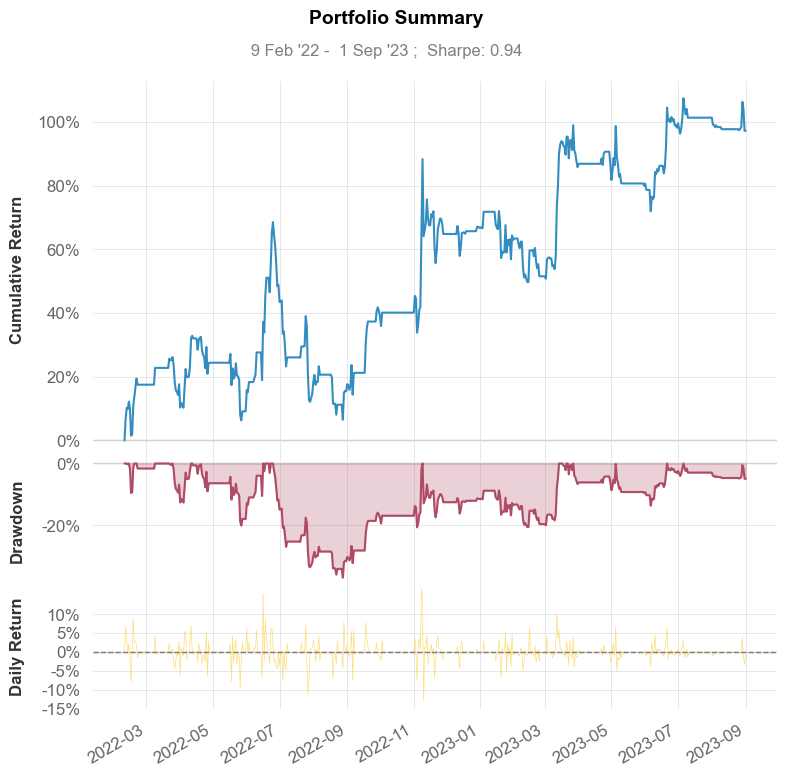

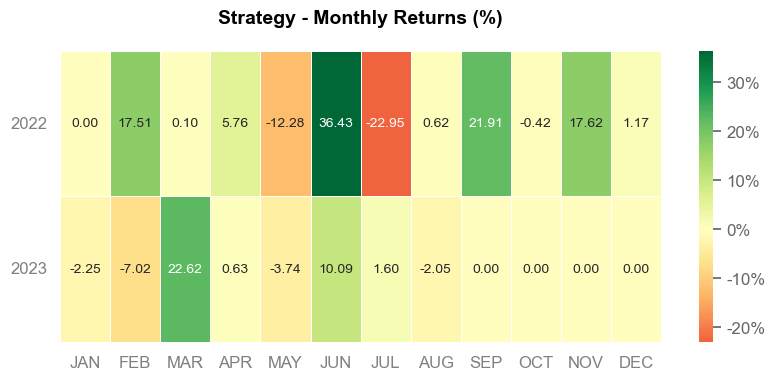

In [5]:
file = "BIAS_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])

With 0.05% transaction cost

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   84.32%
CAGR﹪              31.17%

Sharpe              0.86
Prob. Sharpe Ratio  90.72%
Sortino             1.37
Sortino/√2          0.97
Omega               1.25

Max Drawdown        -37.36%
Longest DD Days     136

Gain/Pain Ratio     0.25
Gain/Pain (1M)      1.52

Payoff Ratio        1.26
Profit Factor       1.25
Common Sense Ratio  1.53
CPC Index           0.78
Tail Ratio          1.22
Outlier Win Ratio   8.6
Outlier Loss Ratio  3.5

MTD                 0.0%
3M                  8.25%
6M                  26.98%
YTD                 14.19%
1Y                  63.14%
3Y (ann.)           31.17%
5Y (ann.)           31.17%
10Y (ann.)          31.17%
All-time (ann.)     31.17%

Avg. Drawdown       -8.68%
Avg. Drawdown Days  33
Recovery Factor     2.14
Ulcer Index         0.15
Serenity Index      0.53


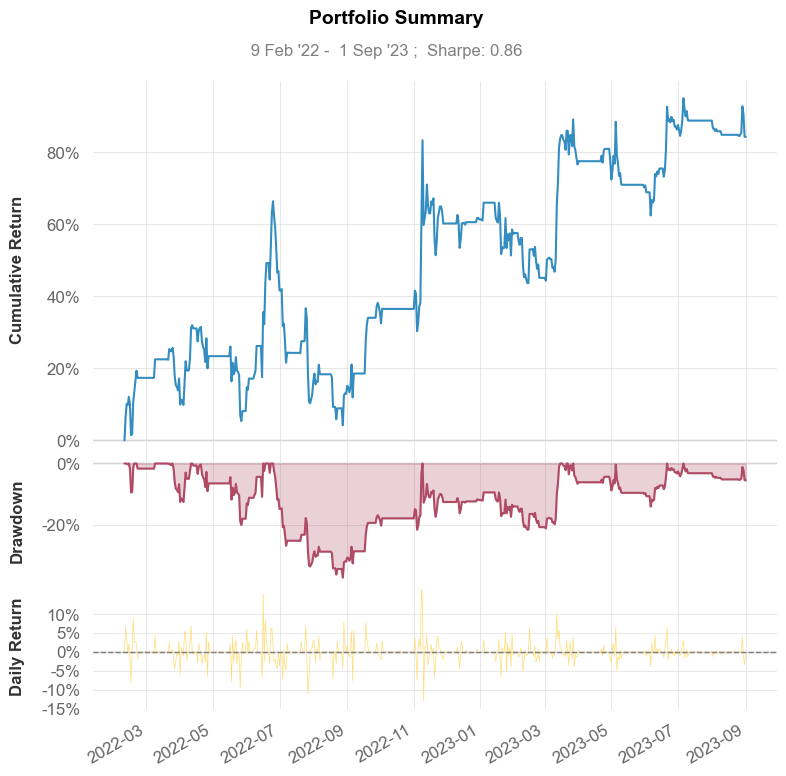

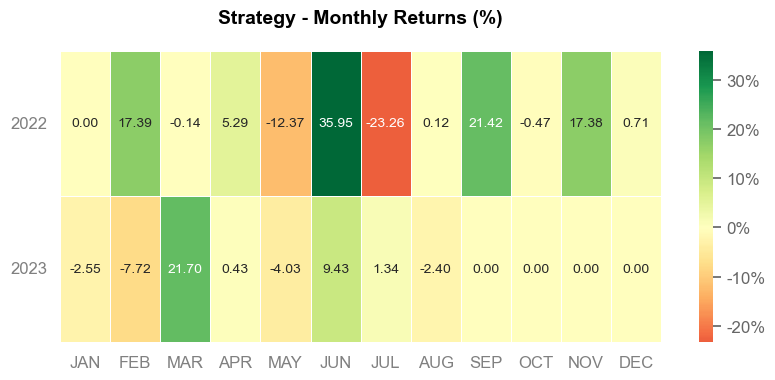

In [6]:
qs.reports.basic(df["Pnl"])

Factor3: Price-Volume Correlation

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      56.0%

Cumulative Return   293.4%
CAGR﹪              83.61%

Sharpe              1.67
Prob. Sharpe Ratio  99.6%
Sortino             2.93
Sortino/√2          2.07
Omega               1.58

Max Drawdown        -31.56%
Longest DD Days     116

Gain/Pain Ratio     0.58
Gain/Pain (1M)      3.14

Payoff Ratio        1.44
Profit Factor       1.58
Common Sense Ratio  2.44
CPC Index           1.19
Tail Ratio          1.54
Outlier Win Ratio   9.66
Outlier Loss Ratio  4.3

MTD                 0.0%
3M                  13.52%
6M                  15.49%
YTD                 43.85%
1Y                  100.3%
3Y (ann.)           83.61%
5Y (ann.)           83.61%
10Y (ann.)          83.61%
All-time (ann.)     83.61%

Avg. Drawdown       -6.72%
Avg. Drawdown Days  21
Recovery Factor     4.94
Ulcer Index         0.1
Serenity Index      2.1


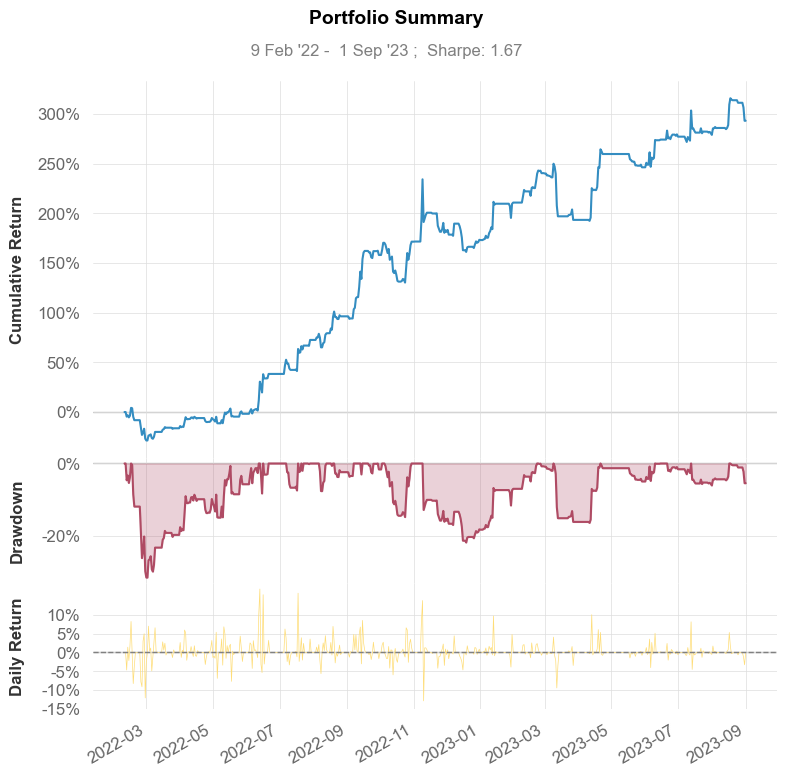

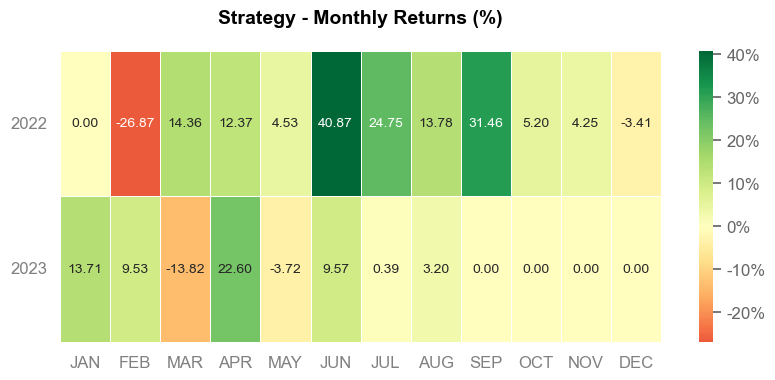

In [7]:
file = "PV_Corr_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])

With 0.05% transaction cost

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      57.0%

Cumulative Return   242.86%
CAGR﹪              72.75%

Sharpe              1.52
Prob. Sharpe Ratio  99.21%
Sortino             2.66
Sortino/√2          1.88
Omega               1.52

Max Drawdown        -31.66%
Longest DD Days     116

Gain/Pain Ratio     0.52
Gain/Pain (1M)      2.72

Payoff Ratio        1.48
Profit Factor       1.52
Common Sense Ratio  2.31
CPC Index           1.13
Tail Ratio          1.52
Outlier Win Ratio   9.64
Outlier Loss Ratio  4.43

MTD                 0.0%
3M                  11.22%
6M                  11.46%
YTD                 36.97%
1Y                  84.82%
3Y (ann.)           72.75%
5Y (ann.)           72.75%
10Y (ann.)          72.75%
All-time (ann.)     72.75%

Avg. Drawdown       -6.88%
Avg. Drawdown Days  22
Recovery Factor     4.49
Ulcer Index         0.11
Serenity Index      1

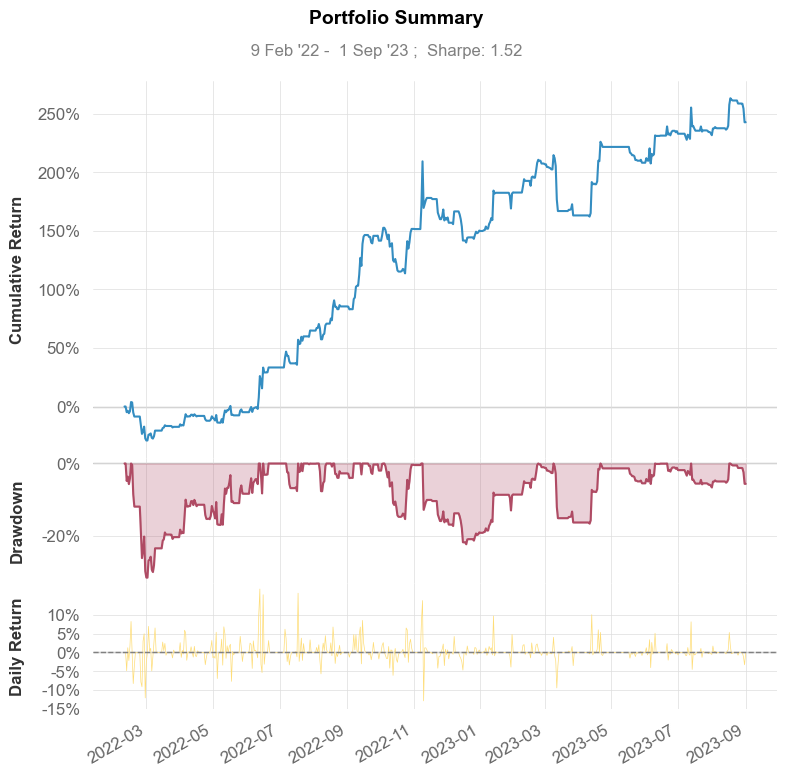

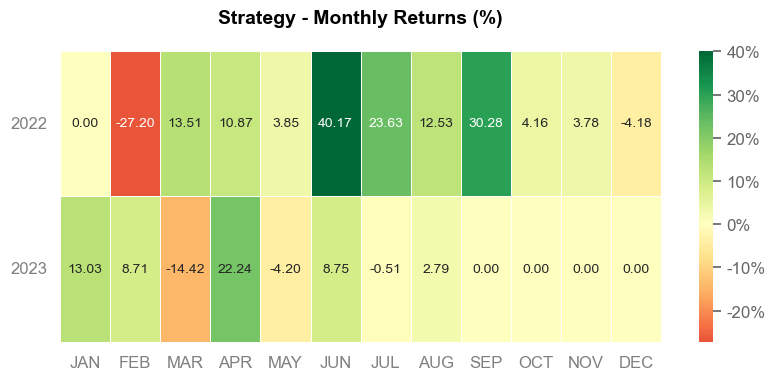

In [8]:
qs.reports.basic(df["Pnl"])

There is no big difference between Pnl with Transaction cost and without Transcation cost